In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torchvision

In [2]:
# Use your own path ;)
mnist_train = torchvision.datasets.MNIST('Data/mnist', train=True, download=False,
                                         transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                         ]))

In [3]:
x_train = mnist_train.data.type(torch.float32)
x_train /= 255.
y_train = mnist_train.targets

In [4]:
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


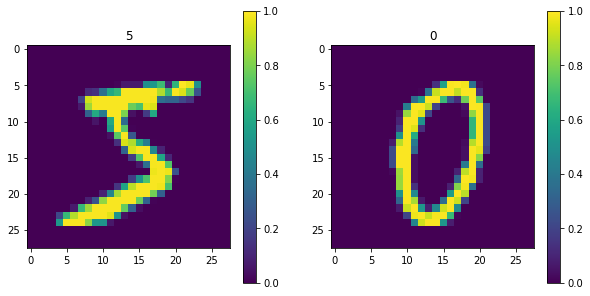

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.title(y_train[0].item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000])
plt.colorbar()
plt.title(y_train[1000].item());

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

In [6]:
class MyModel_FullyDense(nn.Module):
    def __init__(self):
        super(MyModel_FullyDense, self).__init__()
        self.dense1 = nn.Linear(28*28,32)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(32,10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return self.softmax(x)

In [7]:
 class MyModel_FullyConv(nn.Module):
    def __init__(self):
        super(MyModel_FullyConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)       # 28-2 = 26
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)      # -2   = 24
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)  # /2   = 12
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)      # -2   = 10
        # - - - - - - - - - 
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)  # /2   = 5
        self.conv4 = nn.Conv2d(10, 10, kernel_size=5)      # -4   = 10
        self.flat  = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)        
        x = F.relu(self.conv4(x))
        x = self.flat(x)
        return F.softmax(x,dim=1)

In [8]:
 class MyModel_Mixed(nn.Module):
    def __init__(self):
        super(MyModel_Mixed, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x,dim=1)

# 2. Test if model runs

In [9]:
model_fdense = MyModel_FullyDense()
model_fdense.eval()
model_fdense(x_train[0].flatten().unsqueeze(0))

tensor([[0.0916, 0.0917, 0.1273, 0.0872, 0.0903, 0.0958, 0.0969, 0.1047, 0.1128,
         0.1016]], grad_fn=<SoftmaxBackward>)

In [10]:
model_fconv = MyModel_FullyConv()
model_fconv.eval()
model_fconv(x_train[0:1].unsqueeze(1))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SoftmaxBackward>)

In [11]:
model_mixed = MyModel_Mixed()
model_mixed.eval()
model_mixed(x_train[0:1].unsqueeze(1))

tensor([[0.0937, 0.0911, 0.0977, 0.1047, 0.1040, 0.0915, 0.1082, 0.0941, 0.1079,
         0.1073]], grad_fn=<SoftmaxBackward>)

# 3. Choose loss-function and optimizer

In [12]:
loss_function = F.nll_loss
optimizer_fdense = torch.optim.Adam(model_fdense.parameters(), lr=0.0001)
optimizer_fconv = torch.optim.Adam(model_fconv.parameters(), lr=0.0001)
optimizer_mixed = torch.optim.Adam(model_mixed.parameters(), lr=0.0001)

# 4. Write train-loop + train

__Note:__ If you want to train on GPU just call `model.cuda()` to move the model to GPU. Don't forget to move the training data to GPU as well. You can call `x.cuda()` to move a tensor to GPU.

In [13]:
def train(model, x, y, loss_function, optimizer, num_epochs):
    # Make sure that the model is in train-mode
    model.train()
    first = True
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = x_.unsqueeze(0)
            y_ = y_.unsqueeze(0)
            if first:
                print(x_.shape)
                print(y_.shape)
#                 first = False

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x_)
            if first:
#                 print(y_hat)
                print(y_hat.shape)
#                 first = False

            loss = loss_function(y_hat, y_)
            if first:
                print(loss)
                first = False

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # .item() returns the scalar value of the tensor.
            
        running_loss /= len(x)
        print('Epoch: %3d; Train-Loss: %.7f'%(e+1, running_loss))
        running_loss = 0.0

In [14]:
model_fdense.train()
train(model_fdense, x_train[:1000].flatten(start_dim=1), y_train, loss_function, optimizer_fdense, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 784])
torch.Size([1])
torch.Size([1, 10])
tensor(-0.0958, grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: -0.1454299
Epoch:   2; Train-Loss: -0.3511623
Epoch:   3; Train-Loss: -0.5182946
Epoch:   4; Train-Loss: -0.5971208
Epoch:   5; Train-Loss: -0.6466031
Epoch:   6; Train-Loss: -0.6895949
Epoch:   7; Train-Loss: -0.7337380
Epoch:   8; Train-Loss: -0.7651151
Epoch:   9; Train-Loss: -0.7886125
Epoch:  10; Train-Loss: -0.8074214


In [15]:
model_fconv.train()
train(model_fconv, x_train[:1000].unsqueeze(1), y_train, loss_function, optimizer_fconv, 3)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1])
torch.Size([1, 10])
tensor(nan, grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: nan
Epoch:   2; Train-Loss: nan
Epoch:   3; Train-Loss: nan


In [16]:
model_mixed.train()
train(model_mixed, x_train[:1000].unsqueeze(1), y_train, loss_function, optimizer_mixed, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1])
torch.Size([1, 10])
tensor(-0.0950, grad_fn=<NllLossBackward>)
Epoch:   1; Train-Loss: -0.1035657
Epoch:   2; Train-Loss: -0.1735227
Epoch:   3; Train-Loss: -0.3704089
Epoch:   4; Train-Loss: -0.4892213
Epoch:   5; Train-Loss: -0.5432482
Epoch:   6; Train-Loss: -0.5751317
Epoch:   7; Train-Loss: -0.5976481
Epoch:   8; Train-Loss: -0.6185282
Epoch:   9; Train-Loss: -0.6404824
Epoch:  10; Train-Loss: -0.6410763


# 5. Evaluate

In [17]:
model_fdense.eval()
preds_fdense = model_fdense(x_train.flatten(start_dim=1))

In [18]:
model_fconv.eval()
preds_fconv = model_fconv(x_train.unsqueeze(1))

In [19]:
model_mixed.eval()
preds_mixed = model_mixed(x_train.unsqueeze(1))

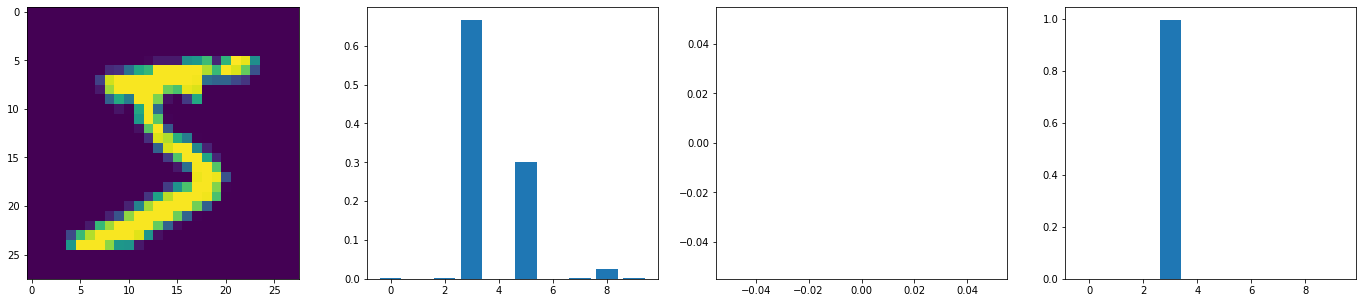

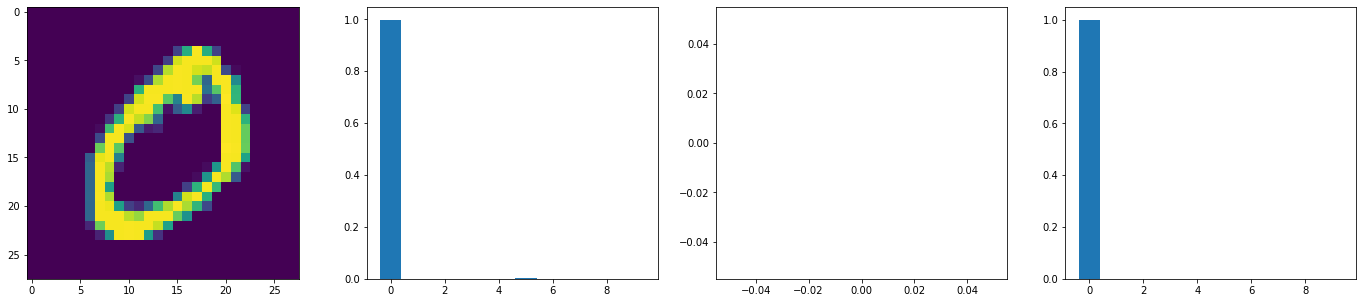

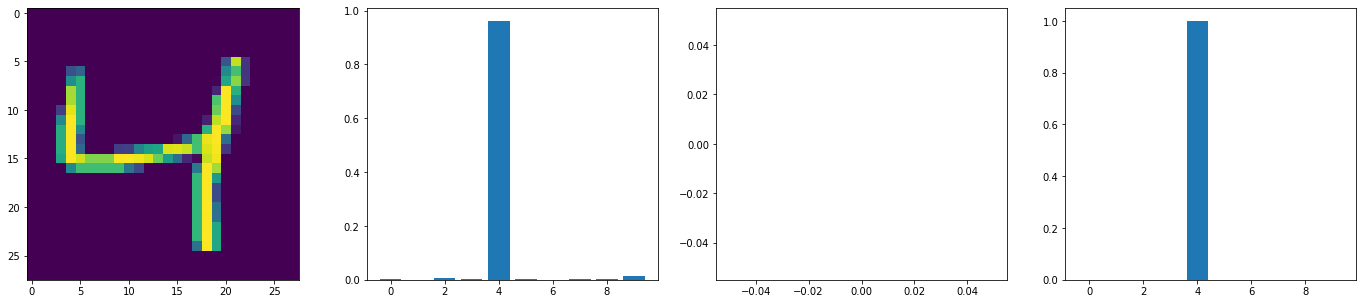

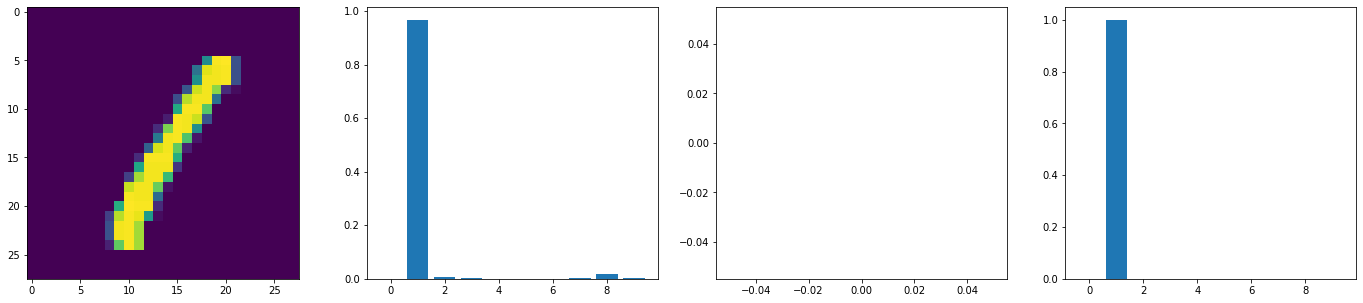

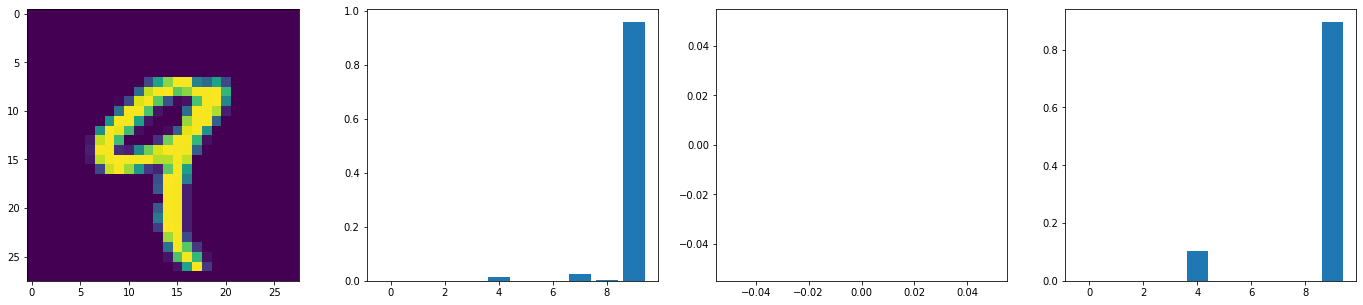

In [20]:
def plotarow(i,results):
    plt.figure(figsize=(8*len(results),5))
    plt.subplot(1,1+len(results),1)
    plt.imshow(x_train[i])
    for j in range(len(results)):
        plt.subplot(1,1+len(results),2+j)
        plt.bar([0,1,2,3,4,5,6,7,8,9],results[j].detach()[i])

for i in range(5):
    plotarow(i,[preds_fdense,preds_fconv,preds_mixed])

### Create Noisy Data

In [21]:
sig_train = x_train[:50000]
sig_test = x_train[50000:]

In [22]:
sig_train.dtype

torch.float32

In [23]:
def noise(imgs,sigma=.33):
    return imgs+np.array( np.random.normal(0, sigma, size=imgs.shape), dtype=np.float32)

    
noisy_train = noise(sig_train)
noisy_test = noise(sig_test)

In [24]:
noisy_train.dtype

torch.float32

In [25]:
noisy_test[0].detach().numpy()

array([[ 4.76579309e-01,  1.68341413e-01, -2.66526520e-01,
         2.80086011e-01, -5.29246926e-01,  7.66457096e-02,
        -5.30303597e-01, -5.22480249e-01, -2.78478749e-02,
         1.68290660e-01, -6.73847198e-02,  6.83171749e-01,
         3.69925141e-01, -3.80763352e-01,  1.11719266e-01,
         1.23506524e-01,  1.29545346e-01, -2.49236360e-01,
        -9.09054130e-02,  2.60977358e-01,  1.73977271e-01,
        -4.61974323e-01,  7.77953506e-01, -4.14458245e-01,
         1.93521500e-01, -2.03042477e-01,  1.35680944e-01,
         1.23264022e-01],
       [-8.57642770e-01, -3.70580256e-01,  6.44546971e-02,
         2.80176699e-01, -4.94249922e-04,  4.93807673e-01,
        -7.93551877e-02,  3.94116044e-02,  7.41153717e-01,
         3.45066279e-01, -1.07941940e-01,  3.01338106e-01,
        -7.48098269e-02, -2.52965808e-01, -2.69253314e-01,
         4.87741619e-01,  4.30914164e-01,  2.34567747e-01,
         4.33692783e-01,  6.66631281e-01,  1.29785135e-01,
        -3.84319752e-01, -6.74

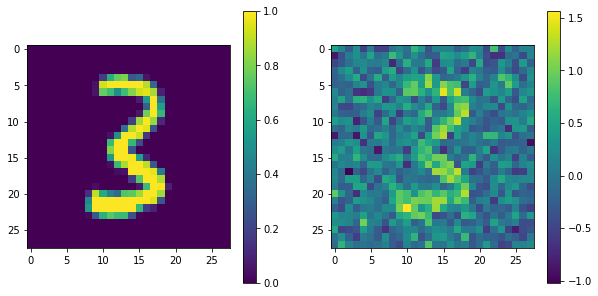

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sig_test[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noisy_test[0])
plt.colorbar()

### Create Network

In [27]:
class MyModel_Denoise(nn.Module):
    def __init__(self):
        super(MyModel_Denoise, self).__init__()
        self.conv1 = nn.Conv2d(1, 10,  kernel_size=3, padding=(1,1))#, padding_mode='reflect')
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding=(1,1))#, padding_mode='reflect')
        self.conv3 = nn.Conv2d(20, 1,  kernel_size=3, padding=(1,1))#, padding_mode='reflect')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

### Train

In [28]:
model_denoise = MyModel_Denoise()
loss_denoise = F.mse_loss
optimizer_denoise = torch.optim.Adam(model_denoise.parameters(), lr=0.0001)
# optimizer_denoise = torch.optim.SGD(model_denoise.parameters(), lr=0.0001)

In [29]:
model_denoise.eval()
model_denoise(noisy_test[0:1].unsqueeze(0))

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., nan, nan, nan],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., nan, nan, nan],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., nan, nan, nan],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [30]:
model_denoise.train()
train(model_denoise, noisy_train[:1000].unsqueeze(1), sig_train[:1000].unsqueeze(1), 
      loss_denoise, optimizer_denoise, 3)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor(0.1165, grad_fn=<MseLossBackward>)
Epoch:   1; Train-Loss: nan
Epoch:   2; Train-Loss: nan
Epoch:   3; Train-Loss: nan


### Evaluate

In [31]:
model_denoise.eval()
denoised = model_denoise(noisy_test.unsqueeze(1).float())

/Users/jug/miniforge3/envs/dlpt/lib/python3.9/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/jug/miniforge3/envs/dlpt/lib/python3.9/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/jug/miniforge3/envs/dlpt/lib/python3.9/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


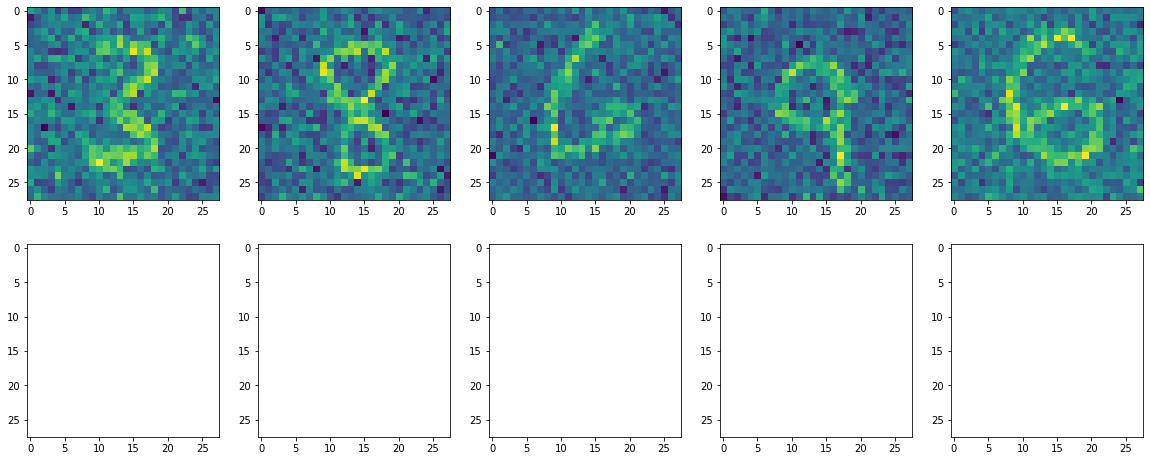

In [32]:
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(noisy_test[i])
for i in range(5):
    plt.subplot(2,5,6+i)
    plt.imshow(denoised.detach().numpy()[i][0])